## Having Fun with Syslog.
<img align="right" src="http://www.sharielf.com/gifs/zz032411pony.jpg" width="180px">

In the next exercise we're going look at some syslog data. We'll take it up a notch by computing similarities with 'Banded MinHash' and running a hierarchical clustering algorithm.

Systems logs are particularly challenging because they often lack any kind of structure as all. For this exercise we're going to be looking at the /var/log/system.log of a typical Mac OSX Laptop. The first steps will be standard data inspection and plots, after that we'll pull out the big guns!

<br><br><br>
<br><br><br>
<figcaption>Image courtesy of Shari Elf: www.sharielf.com</figcaption>

In [1]:
# This exercise is mostly for us to understand what kind of data we have and then
# run some simple stats on the fields/values in the data. Pandas will be great for that
import pandas as pd
pd.__version__

'0.13.0rc1-32-g81053f9'

In [2]:
# Set default figure sizes
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

In [3]:
# Lets take a peek at our system.log, with IPython you
# can execute system commands with '!' (also see %alias)

In [4]:
!head /var/log/system.log

Jan 11 00:16:09 voltron kernel[0]: Wake reason: RTC (Alarm)
Jan 11 00:16:09 voltron kernel[0]: RTC: SleepService 2014/1/11 07:16:09, sleep 2014/1/11 06:16:16
Jan 11 00:16:09 voltron kernel[0]: AirPort_Brcm43xx::powerChange: System Wake - Full Wake/ Dark Wake / Maintenance wake
Jan 11 00:16:09 voltron kernel[0]: Previous Sleep Cause: 5
Jan 11 00:16:09 voltron kernel[0]: IOPPF: Sent gpu-internal-plimit-notification last value 0 (rounded time weighted average 0)
Jan 11 00:16:09 voltron kernel[0]: IOThunderboltSwitch<0xffffff8042864000>(0x0)::listenerCallback - Thunderbolt HPD packet for route = 0x0 port = 11 unplug = 0
Jan 11 00:16:09 voltron kernel[0]: IOThunderboltSwitch<0xffffff8042864000>(0x0)::listenerCallback - Thunderbolt HPD packet for route = 0x0 port = 12 unplug = 0
Jan 11 00:16:09 voltron kernel[0]: wlEvent: en0 en0 Link DOWN virtIf = 0
Jan 11 00:16:09 voltron kernel[0]: AirPort: Link Down on en0. Reason 8 (Disassociated because station leaving).
Jan 11 00:16:09 voltron kernel[

In [5]:
# Okay so weird timestamp, machine name and then random stuff...
import dateutil.parser

In [8]:
# Helper function to make compact, composite labels for the syslog rows
def make_label(features):
    return unicode(':'.join([f[:6] for f in features]), 'utf-8').encode('ascii','ignore')

# Now process the syslog file, part of the challenge is parsing the darn thing.
# Typically each row in a syslog will have a timestamp first and then some random
# set of other fields split on whitespace. We're going to carefully pull out the
# timestamp but then just treat everything else as bag of tokens (sparse data).
date_index = []
with open('/var/log/system.log') as syslog:
    syslog_rows = syslog.readlines()
    syslog_events = []
    for row in syslog_rows:
        split_list = row.split()
        date_string = ' '.join(split_list[:3])
        try:
            date = dateutil.parser.parse(date_string)
        except (ValueError, TypeError) as e:
            continue # Going to skip rows where we can't get a timestamp
        features = split_list[4:]
        syslog_events.append({'features': features, 'label': make_label(features), 'type': features[0].split('[')[0]})
        date_index.append(date)
    dataframe = pd.DataFrame(syslog_events, index=date_index)

In [9]:
# Make sure our timestamp got pulled/parsed/converted correctly
type(dataframe.index[0])

pandas.tslib.Timestamp

In [10]:
dataframe.head(5)

# So what do we have? Datetime is our index, features is just the 
# syslog row split by whitespace and placed into a list. The label
# is just the features (truncated) and flattened with : separators.
# 'type' is just the syslog identifier right after the datetime and machine.
# Note: The parsing of the syslog is more art than science and syslogs
#       can vary greatly, but we haven't done any super magic here,
#       just basically thrown the row data into some bins...

features  \
2014-01-11 00:16:09          [kernel[0]:, Wake, reason:, RTC, (Alarm)]   
2014-01-11 00:16:09  [kernel[0]:, RTC:, SleepService, 2014/1/11, 07...   
2014-01-11 00:16:09  [kernel[0]:, AirPort_Brcm43xx::powerChange:, S...   
2014-01-11 00:16:09           [kernel[0]:, Previous, Sleep, Cause:, 5]   
2014-01-11 00:16:09  [kernel[0]:, IOPPF:, Sent, gpu-internal-plimit...   

                                                                 label    type  
2014-01-11 00:16:09                      kernel:Wake:reason:RTC:(Alarm  kernel  
2014-01-11 00:16:09  kernel:RTC::SleepS:2014/1:07:16::sleep:2014/1:...  kernel  
2014-01-11 00:16:09  kernel:AirPor:System:Wake:-:Full:Wake/:Dark:Wa...  kernel  
2014-01-11 00:16:09                       kernel:Previo:Sleep:Cause::5  kernel  
2014-01-11 00:16:09  kernel:IOPPF::Sent:gpu-in:last:value:0:(round:...  kernel  

[5 rows x 3 columns]

In [11]:
dataframe.tail(5)

features  \
2014-01-11 14:03:10  [Google, Chrome, Helper[9524]:, CoreText, Copy...   
2014-01-11 14:03:10            [last, message, repeated, 1, time, ---]   
2014-01-11 14:03:10  [kernel[0]:, SMC::smcReadKeyAction, ERROR, TC0...   
2014-01-11 14:03:40          [last, message, repeated, 24, times, ---]   
2014-01-11 14:03:40  [kernel[0]:, SMC::smcReadKeyAction, ERROR, TC0...   

                                                                 label    type  
2014-01-11 14:03:10  Google:Chrome:Helper:CoreTe:CopyFo:receiv:mig:...  Google  
2014-01-11 14:03:10                      last:messag:repeat:1:time:---    last  
2014-01-11 14:03:10             kernel:SMC::s:ERROR:TC0D:kSMCBa:fKeyHa  kernel  
2014-01-11 14:03:40                    last:messag:repeat:24:times:---    last  
2014-01-11 14:03:40             kernel:SMC::s:ERROR:TC0D:kSMCBa:fKeyHa  kernel  

[5 rows x 3 columns]

In [12]:
# We can get a count of all the unique values by running value_counts()
dataframe['label'].value_counts()

# Okay the breakout below gives us a sense for our challenge...

kernel:SMC::s:ERROR:TC0D:kSMCBa:fKeyHa                          651
last:messag:repeat:24:times:---                                 539
last:messag:repeat:1:time:---                                    27
config:networ:change:v4(en0:v6(en0:DNS!:Proxy:SMB                26
Google:Chrome:Helper:Intern:of:CFAllo:not:known;:out-of:failur:via:CFAllo:will:not:result:in:termin:http:/     18
Google:Chrome:Helper:CGSLoo:Failed:to:look:up:the:port:for:"com.a:(1100)     17
Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch:::LSXPCC:#426:___ZN2:q=com.     17
Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch     17
kernel:IOThun:-:Thunde:HPD:packet:for:route:=:0x0:port:=:11:unplug:=:0     16
last:messag:repeat:2:times:---                                   14
kernel:IOThun:-:Thunde:HPD:packet:for:route:=:0x0:port:=

In [13]:
# Realize that we don't want the 'last message' events
dataframe = dataframe[dataframe['type'] != 'last']

### Lets do standard histogram and event volume over time plots

Subset: 1227 rows 3 columns


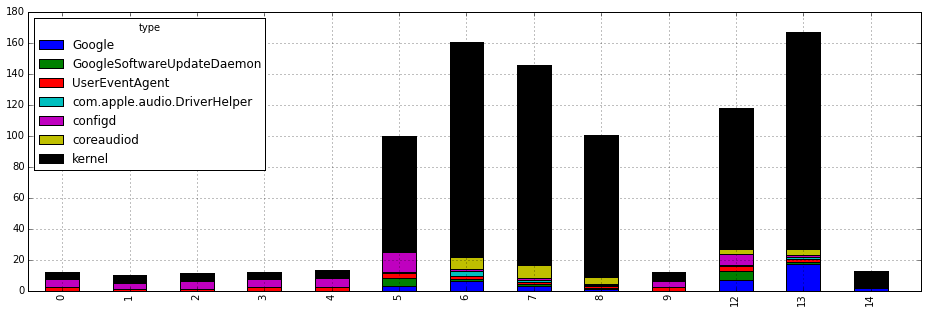

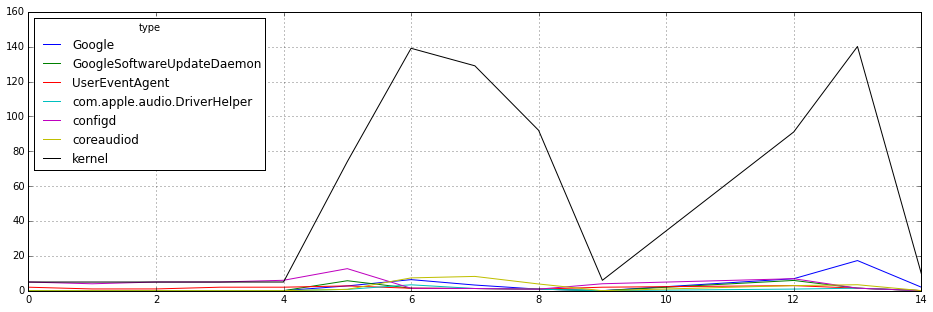

In [14]:
# Now prepare the data for plotting by pivoting on the 
# feature to create a new column (series) for each value

# Only pull out the top 7 syslog event types
topN = dataframe['type'].value_counts()[:7].index
subset = dataframe[dataframe['type'].isin(topN)]
print 'Subset: %d rows %d columns' % subset.shape

# We're going to add a new column called value (needed for pivot). This
# is a bit dorky, but needed as the new columns that get created should
# really have a value in them, also we can use this as our value to sum over.
subset['count'] = 1
pivot = pd.pivot_table(subset, values='count', rows=subset.index, cols=['type'], fill_value=.01)
by = lambda x: lambda y: getattr(y, x)
grouped = pivot.groupby([by('hour')]).sum()
grouped.plot(kind='bar', stacked=True)
grouped.plot()

<img align="right" src="files/images/spice_weasel.jpg" width="300px" style="margin: 10px">

#### Well besides learning we have lots of kernel syslog messages, kinda boring...<br><br>So, lets take is up a notch with the good 'ol spice weasel! Bam!
1. **Compute similarities between all rows within the system log using LSH**
    Unlike conventional hash functions the goal of LSH (Locality Sensitive Hashing) is to maximize probability of "collision" of similar items rather than avoid collisions.
    * [MinHash](http://en.wikipedia.org/wiki/MinHash)
    * [Locality Sensitive Hashing](http://en.wikipedia.org/wiki/Locality_sensitive_hashing)
    * [Mining of Massive Datasets](http://infolab.stanford.edu/~ullman/mmds/ch3.pdf)
2. **Use those similarities as the basis of a Hierarchical Clustering Algorithm**
    Single-linkage clustering is one of several methods for agglomerative 
    hierarchical clustering.
    - [Single Linkage Clustering](http://en.wikipedia.org/wiki/Single-linkage_clustering)
    - [Hierarchical Clustering](http://en.wikipedia.org/wiki/Hierarchical_clustering)
    
    Other popular online clustering algorithms
    - [DBSCAN](http://en.wikipedia.org/wiki/DBSCAN)
    - [OPTICS Algorithms](http://en.wikipedia.org/wiki/OPTICS_algorithm)

In [15]:
# Even for small syslogs the number of similarity pairs to compute quickly
# becomes quite large O(N**2), so for 100k rows that's 10 billion possible
# pairs. Using Banded MinHash will drastically reduce the number of 
# candidates that we have to compute.
import data_hacking.lsh_sims as lsh_sims

# Note: The parameters here are setup for feeding the results into a Hierarchical
#       Clustering algorithm, which needs as many similarities as you can get.
#       In general you'd parameters like num_hashes:20, lsh_bands:5 lsh_rows:4  
#       Note: lsh_bands*lsh_rows ^must^ equal num_hashes
params = {'num_hashes':20, 'lsh_bands':20, 'lsh_rows':1, 'drop_duplicates':True}
lsh = lsh_sims.LSHSimilarities(dataframe['features'], mh_params=params)
sims = lsh.batch_compute_similarities(distance_metric='jaccard', threshold=.2)

12694 (0.64% out of 1979649) pairs returned from MinHash


#### The LSH Sims python class has two distance metrics

1) Jaccard Index: a set based distance metric (overlaps in sets of elements)
  
   - [Jaccard Index](http://en.wikipedia.org/wiki/Jaccard_index)

2) Levenshtein Distance: based on the edit distance of the elements (so order matters).
  
   - [Levenshtein Distance](http://en.wikipedia.org/wiki/Levenshtein_distance)

In [16]:
# Lets look at the difference between Jaccard Similarity and Levenshtein Similarity
# So here similarity is a normalized measure of inverse distance...
print 'Jaccard Index (Sim): %f ' % lsh.jaccard_sim(['a','b','c','d'], ['a','b','d','c'])
print 'Levenshtein Distance: %f ' % lsh.levenshtein(['a','b','c','d'], ['a','b','d','c'])
print 'Levenshtein (Sim): %f ' % lsh.l_sim(['a','b','c','d'], ['a','b','d','c'])

Jaccard Index (Sim): 1.000000 
Levenshtein Distance: 2.000000 
Levenshtein (Sim): 0.500000 


In [17]:
# One more example for intuition (also note they don't have to be the same size)
print 'Jaccard Index (Sim): %f ' % lsh.jaccard_sim(['a','b','c'], ['a','b','c','x'])
print 'Levenshtein Distance: %f ' % lsh.levenshtein(['a','b','c'], ['a','b','c','x'])
print 'Levenshtein (Sim): %f ' % lsh.l_sim(['a','b','c'], ['a','b','c','x'])

Jaccard Index (Sim): 0.750000 
Levenshtein Distance: 1.000000 
Levenshtein (Sim): 0.750000 


In [18]:
# Okay now that we have the similarities between all the rows in our syslog
# we can start to investigate the results.
sims.sort(reverse=True)
print '*** Top sims ***'
sims[:10]
#sims[-10:]

*** Top sims ***


[(1.0, 277, 1186),
 (0.9705882352941176, 376, 1090),
 (0.9666666666666667, 375, 1089),
 (0.9629629629629629, 1382, 1400),
 (0.9629629629629629, 1355, 1400),
 (0.9629629629629629, 1355, 1382),
 (0.9629629629629629, 1343, 1400),
 (0.9629629629629629, 1343, 1382),
 (0.9629629629629629, 1343, 1355),
 (0.9629629629629629, 1334, 1400)]

In [20]:
print dataframe.iloc[376]['features']

['System', 'Events[8642]:', '.sdef', 'warning', 'for', 'type', "'text", '|', 'missing', 'value', '|', "any'", 'attribute', "'uniqueID'", 'of', 'class', "'XML", "element'", 'in', 'suite', "'XML", "Suite':", 'AppleScript', 'ID', 'references', 'may', 'not', 'work', 'for', 'this', 'property', 'because', 'its', 'type', 'is', 'not', 'NSNumber-', 'or', 'NSString-derived.']


In [21]:
print dataframe.iloc[1090]['features']

['System', 'Events[9028]:', '.sdef', 'warning', 'for', 'type', "'text", '|', 'missing', 'value', '|', "any'", 'attribute', "'uniqueID'", 'of', 'class', "'XML", "element'", 'in', 'suite', "'XML", "Suite':", 'AppleScript', 'ID', 'references', 'may', 'not', 'work', 'for', 'this', 'property', 'because', 'its', 'type', 'is', 'not', 'NSNumber-', 'or', 'NSString-derived.']


In [22]:
# The two feature sets should look quite similar (recall that this
# is just our syslog row split on white space and thrown into a list)

# So now for any row in our syslog we can see what rows are highly
# similar to that row.
query_item = ['Google', 'Chrome', 'Helper[11545]:', 'Process', 'unable', 'to', 'create', 'connection', 'because', 'the', 'sandbox', 'denied', 'the', 'right', 'to', 'lookup', 'com.apple.coreservices.launchservicesd', 'and', 'so', 'this', 'process', 'cannot', 'talk', 'to', 'launchservicesd.', ':', 'LSXPCClient.cp', '#426', '___ZN26LSClientToServerConnection21setupServerConnectionEiPK14__CFDictionary_block_invoke()', 'q=com.apple.main-thread']
lsh.top_N(query_item,dataframe['label'], 5)


[{'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch:::LSXPCC:#426:___ZN2:q=com.',
  'sim': 0.9629629629629629},
 {'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch:::LSXPCC:#426:___ZN2:q=com.',
  'sim': 0.9629629629629629},
 {'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch:::LSXPCC:#426:___ZN2:q=com.',
  'sim': 0.9629629629629629},
 {'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch:::LSXPCC:#426:___ZN2:q=com.',
  'sim': 0.9629629629629629},
 {'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proc

In [23]:
# Note the query object doesn't have all the original features
query_item = ['Google', 'Chrome', 'Process', 'unable', 'to', 'sandbox']
lsh.top_N(query_item,dataframe['label'], 5)

[{'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch',
  'sim': 0.2727272727272727},
 {'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch',
  'sim': 0.2727272727272727},
 {'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch',
  'sim': 0.2727272727272727},
 {'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch',
  'sim': 0.2727272727272727},
 {'label': 'Google:Chrome:Helper:Proces:unable:to:create:connec:becaus:the:sandbo:denied:the:right:to:lookup:com.ap:and:so:this:proces:cannot:talk:to:launch',
  'sim': 0.2727272727272727}]

<div style="float: right; margin: 20px 20px 20px 20px"><img src="files/images/agg.jpg" style="margin: 10px"></div>
### Hierarchical Clustering 
Now we can use those similarities as the basis of a Hierarchical Clustering Algorithm. Single-linkage clustering is one of several methods for agglomerative hierarchical clustering. The image on the right is an example of how this works. 

We're using a bottom up method (image is flipped :), you simply sort the similarities and start building your tree from the bottom. If B and C are the most similar you link them, then D/E and so on until you complete the tree. The devil is **definitely** in the details on the implementation of this, so luckily we have a python class that does it for us.

10 (12.35% out of 81) pairs returned from MinHash


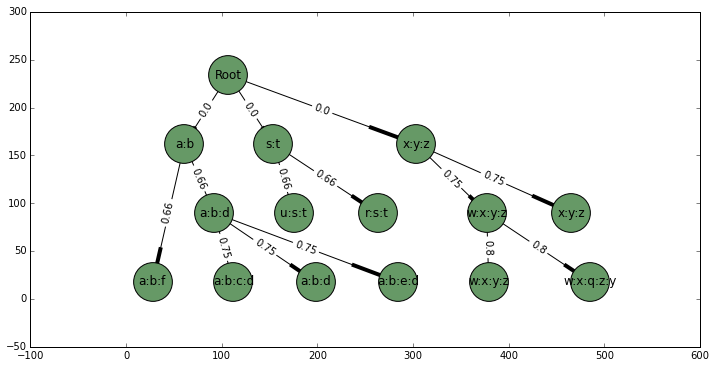

In [30]:
# A simple example for illustration
import data_hacking.hcluster as hcluster

toy_data = [['a','b','c','d'],['a','b','d'],['a','b','e','d'],['a','b','f'],
            ['w','x','y','z'],['x','y','z'],['w','x','q','z','y'],
            ['r','s','t'],['u','s','t']]

toy_lsh = lsh_sims.LSHSimilarities(toy_data, mh_params=params)
toy_sims = toy_lsh.batch_compute_similarities(distance_metric='jaccard', threshold=.2)
    
# Compute a hierarchical clustering from the similarity list
toy_h_clustering = hcluster.HCluster(toy_data)
toy_h_clustering.set_sim_method(toy_lsh.jaccard_sim)
toy_h_tree, toy_root = toy_h_clustering.sims_to_hcluster(toy_sims)

# Plot the hierarchical tree
toy_h_clustering.plot_htree(toy_h_tree, prog='dot')


In [39]:
# Now we'll do the same thing for our syslog data

# Compute a hierarchical clustering from the similarity list
h_clustering = hcluster.HCluster(dataframe['features'])
h_clustering.set_sim_method(lsh.jaccard_sim)
h_tree, root = h_clustering.sims_to_hcluster(sims, agg_sim=.3)

In [40]:
# Here's an image for those folks not looking at it interactively

<img src="files/images/h_cluster.png">

In [41]:
# Even better save the graph out to json format and visualize it with D3 (D3js.org)
import networkx.readwrite.json_graph
import json
graph_json = networkx.readwrite.json_graph.tree_data(h_tree, root=root)
json.dump(graph_json, open('h_tree.json','w'))

#### Please note the D3 vis below is embryonic, hoping to make it super cool...
To run the visualization in your web browser, here we're using port 9999 instead of standard 8888 because we may have IPython already running on 8888:

<pre>
> cd data_hacking/fun_with_syslog
> python -m SimpleHTTPServer 9999 &
</pre>

Now point your brower at the html file [http://localhost:9999/syslog_vis.html](http://localhost:9999/syslog_vis.html)

<img src="files/images/h_cluster_d3.png" width=600 style="margin: 10px">

### ToDo
Really want to improve the interactive D3 based Hierarchical Tree Visualization [D3 Data Driven Documents](http://d3js.org)

### Conclusions
We pulled in some syslog data into a Pandas dataframe, made some plots, computed row similarities with 'Banded MinHash' and used single-linkage clustering to build an agglomerative hierarchical cluster. Lots of possibilities from here, you could use just the LSH datastructure or the H-Cluster...

  - LogFile Viewer
    - Click on a row, filter out everything that's similar
    - Click on a row, color code all the other rows based on similarity
  - Super fancy D3 zoom in/filter awesomeness...